# $n(z)$ calculations for SV overview paper

In [1]:
import os
import h5py
import sv as SV
import numpy as np
import astropy.table as atable
from astropy.cosmology import FlatLambdaCDM

from desitarget.sv1.sv1_targetmask import bgs_mask as sv1_bgs_mask
from desitarget.sv3.sv3_targetmask import bgs_mask as sv3_bgs_mask

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
dat_dir = '/global/cfs/cdirs/desi/spectro/redux/everest/zcatalog/'
sv1 = atable.Table.read(os.path.join(dat_dir, 'ztile-sv1-bright-cumulative.fits'))
sv3 = atable.Table.read(os.path.join(dat_dir, 'ztile-sv3-bright-cumulative.fits'))#'/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/everest/LSScats/2.1/BGS_ANY_full.dat.fits')   

In [4]:
sv3[:2]

TARGETID,CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKID,BRICK_OBJID,MORPHTYPE,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MASKBITS,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,BRICKNAME,EBV,FLUX_W1,FLUX_W2,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV3_SCND_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,PLATE_RA,PLATE_DEC,TILEID,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,MEAN_FIBER_X,MEAN_FIBER_Y,TSNR2_GPBDARK_B,TSNR2_ELG_B,TSNR2_GPBBRIGHT_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_GPBBACKUP_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_GPBDARK_R,TSNR2_ELG_R,TSNR2_GPBBRIGHT_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_GPBBACKUP_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_GPBDARK_Z,TSNR2_ELG_Z,TSNR2_GPBBRIGHT_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_GPBBACKUP_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_GPBDARK,TSNR2_ELG,TSNR2_GPBBRIGHT,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBBACKUP,TSNR2_QSO,TSNR2_LRG
int64,float64,float64,float64,float64,int64,int64,bytes6,bytes20,int64,float64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int32,float64,int32,int16,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,int16,int64,bytes2,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int32,int16,float32,int16,int16,float32,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
616088637154525577,7469.736961875111,343.341920185407 .. 4.461166245608293,0.1640355753964906,5.34206875304331e-05,5,7888,GALAXY,,10,2.0885551758110523,0,311,311,0,0,209.73714846971205,3.9564394849835423,0.0,0.0,0.0,5400.0,4294967296,4,SKY,79.813156,-285.5409,-1,0.9928253255644854,63,9010,354239,393,,0.0,0.0,0.0,0.0,0.0,0.0,0,0,,0.0,0.0,0.0,0.0,2096p040,0.0,0.0,0.0,0.0,0.0,0.002932687,0.050296437,-0.32439482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,-1,-1,0,0,0,0,4294967296,0,0,209.73714846971205,3.9564394849835423,147,1,547.2114,1,1,0.003,0.003,-0.006,0.006,209.73716026500415,0.0,3.956462500819131,0.0,0.7922114,79.788,-285.475,23.863243,0.013085774,4.6983557,9.864799,76.063774,38.58653,0.34747624,0.13140436,1929.5238,4.1310186,369.23856,0.0073187514,418.62964,2770.6206,1.2766074,5.9954977,3.1019076e-06,14.1808815,6.09562e-07,0.0,678.5658,4.9829587e-06,2.9812157,6.5986357,1953.3871,18.324986,373.93692,9.872117,1173.2593,2809.207,4.6052995,12.725538
39627884855296350,8.999999999999996e+99,0.0 .. 0.0,-0.0019956912923479522,4.1311493573349107e-48,1570,0,STAR,CV,3,1.942668892225729e+84,0,272,272,1,512,209.80570753935638,3.9921168242771152,0.0,0.0,2015.5,5400.0,1152921504609009673,1,TGT,62.678272,-276.09814,102100,0.3370130848906494,517,9010,354240,350,SER,1.4384575,7.465098,23.792833,514.5049,144.19394,20.042986,0,0,,0.0,0.0,0.0,0.0,2099p040,0.033253953,56.904545,38.72192,1.6268853,0.4759606,0.46754184,2.4263809,7.7333846,0.46829304,2.4274113,7.734687,6.0,1.3621521,0.09121728,-0.046635494,S,102100,9,1152921504609009673,65545,0,0,0,0,0,209.80570753935638,3.9921168242771152,147,0,0.0,1,1,0.452,0.452,-1.523,1.523,209.80748214637995,0.

In [5]:
sv1_bright = (sv1['SV1_BGS_TARGET'] & sv1_bgs_mask['BGS_BRIGHT']) != 0 
sv1_faint  = (sv1['SV1_BGS_TARGET'] & sv1_bgs_mask['BGS_FAINT']) != 0 

sv3_bright = (sv3['SV3_BGS_TARGET'] & sv3_bgs_mask['BGS_BRIGHT']) != 0 
sv3_faint  = (sv3['SV3_BGS_TARGET'] & sv3_bgs_mask['BGS_FAINT']) != 0 

In [6]:
sv1_cuts = ((sv1['Z'] != 1e20) & (sv1['ZWARN'] == 0) & (sv1['DELTACHI2'] > 40))
print(np.mean(sv1_cuts))
sv3_cuts = ((sv3['Z'] != 1e20) & (sv3['ZWARN'] == 0) & (sv3['DELTACHI2'] > 40))
print(np.mean(sv3_cuts))

0.6849508196721311
0.707624531835206


In [7]:
print('SV1: BRIGHT %i FAINT %i ALL %i redshifts' % (np.sum(sv1_bright & sv1_cuts), np.sum(sv1_faint & sv1_cuts), np.sum(sv1_bright & sv1_cuts) + np.sum(sv1_faint & sv1_cuts)))
print('SV3: BRIGHT %i FAINT %i ALL %i redshifts' % (np.sum(sv3_bright & sv3_cuts), np.sum(sv3_faint & sv3_cuts), np.sum(sv3_bright & sv3_cuts) + np.sum(sv3_faint & sv3_cuts)))

print('%i total BRIGHT SUCCESSFUL REDSHIFTS' % (np.sum(sv1_bright & sv1_cuts) + np.sum(sv3_bright & sv3_cuts)))
print('%i total FAINT SUCCESSFUL REDSHIFTS' % (np.sum(sv1_faint & sv1_cuts) + np.sum(sv3_faint & sv3_cuts)))

SV1: BRIGHT 51045 FAINT 37361 ALL 88406 redshifts
SV3: BRIGHT 236768 FAINT 165796 ALL 402564 redshifts
287813 total BRIGHT SUCCESSFUL REDSHIFTS
203157 total FAINT SUCCESSFUL REDSHIFTS


In [8]:
def stephist(nh, _edges):
    bin_edges = np.sort(list(_edges) + list(_edges[1:-1]))
    return bin_edges, np.array([[x, x] for x in nh]).flatten()

## get normalized $z$ distribution of SV3

In [21]:
zbins = 0. + 0.05 * np.arange(20)
nh_bright, _ = np.histogram(sv3['Z'][sv3_bright & sv3_cuts], bins=zbins, density=True)
nh_faint, _ = np.histogram(sv3['Z'][sv3_faint & sv3_cuts], bins=zbins, density=True)

(0.0, 0.20366650943019965)

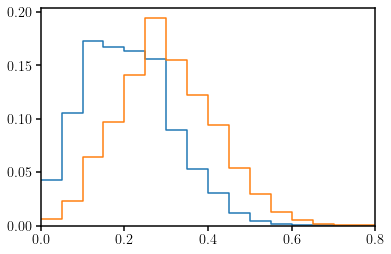

In [24]:
x, y = stephist(nh_bright/np.sum(nh_bright), zbins)
plt.plot(x, y)
x, y = stephist(nh_faint/np.sum(nh_faint), zbins)
plt.plot(x, y)
plt.xlim(0., 0.8)
plt.ylim(0., None)

## calculate $n(z)$
(target density in ${\rm deg}^{-2}$) x (normalized $z$ distribution)

In [25]:
nz_bright = 864. * (nh_bright/np.sum(nh_bright))
nz_faint = 533. * (nh_faint/np.sum(nh_faint))

In [30]:
zlow = zbins[:-1]
zhigh = zbins[1:] 

In [32]:
np.savetxt('bgs_nz_sv_overview.dat', np.vstack([zlow, zhigh, nz_bright, nz_faint]).T, fmt=['%.3f', '%.3f', '%.5e', '%.5e'], header='z_low, z_high, n_bright (deg^-2), n_faint (deg^-2)')